# 一、 决策树

### 1.1 决策树的定义

<center> <img src="images/p040.png" width="700" height="450"/> </center>


构建决策树的步骤如下:
- 从根节点的所有示例开始
- 计算在所有可能的特征上进行分割的信息增益，并选择具有最高信息增益的特征
- 根据选择的特征拆分数据集，并创建树的左右分支
- 重复分裂过程，直到满足停止条件
  1. 决策树已经到底
  2. 某种可能已经达到100%
  3. 信息增益 或者 number 小于某个阈值
   
适合规则的数据（不适合图像、音频、自然语言这些不规则数据）， 训练速度快

### 1.2  Calculate entropy熵（纯度）
用于衡量数据的纯度
$$
H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)
$$
一般$log_a$取$log_2$， 而不是$ln$, 并且定义$0log_2 0=0$。  熵越小表示越纯， 熵越大表示复杂度越高，杂质越多

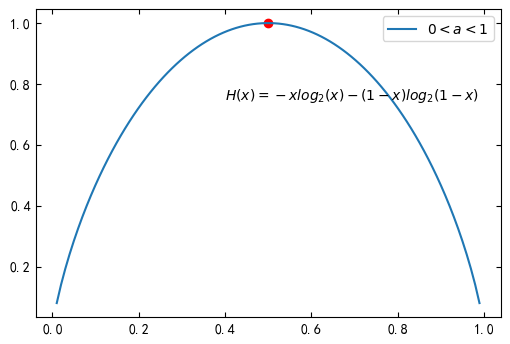

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from my_draw import *
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])
def compute_entropy(y):
    entropy = 0.
    if len(y) != 0: 
        p1 = len(y[y == 1]) / len(y)
        if (p1 != 0) & (p1 != 1):
            entropy = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
        else:
            entropy = 0
    return entropy
draw_entropy()

In [2]:
# 分成两类
def split_dataset(X, node_indices, feature):
    left_indices = []
    right_indices = []
    for ind in node_indices:
        if X[ind][feature] == 1:
            left_indices.append(ind)
        else:
            right_indices.append(ind)
    return left_indices, right_indices

### 1.3 信息增益 information gain
$$
\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))
$$

where 
- $H(p_1^\text{node})$ 为该节点的熵
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ 是拆分后在左右两个分支上的熵
- $w^{\text{left}}$ and $w^{\text{right}}$ 是样本在左分支和右分支的比例
<center> <img src="images/p033.png" width="800" height="400"/> </center>

In [3]:
root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
feature = 0
left_indices, right_indices = split_dataset(X_train, root_indices, feature)
print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

Left indices:  [0, 1, 2, 3, 4, 7, 9]
Right indices:  [5, 6, 8]


In [4]:
# 计算信息增益
def compute_information_gain(X, y, node_indices, feature):
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    information_gain = 0
    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    # Weights 
    w_left  = len(y_left)/len(y_node)
    w_right = len(y_right)/len(y_node)
    w_entropy = w_left * left_entropy +  w_right * right_entropy                                                  
    information_gain = node_entropy - w_entropy   
    return information_gain

info_gain0 = compute_information_gain(X_train, y_train, root_indices, feature=0)
print("Information Gain from splitting the root on brown cap: ", info_gain0)
info_gain1 = compute_information_gain(X_train, y_train, root_indices, feature=1)
print("Information Gain from splitting the root on tapering stalk shape: ", info_gain1)
info_gain2 = compute_information_gain(X_train, y_train, root_indices, feature=2)
print("Information Gain from splitting the root on solitary: ", info_gain2)
# 观察输出可以发现，在根节点上的“隔离”(feature = 2)上的分裂提供了最大的信息增益。因此，它是在根节点上进行分割的最佳特性

Information Gain from splitting the root on brown cap:  0.034851554559677034
Information Gain from splitting the root on tapering stalk shape:  0.12451124978365313
Information Gain from splitting the root on solitary:  0.2780719051126377


### 1.4  分枝选择 split
用能够使得信息增益最大的标准作为分裂依据
<center> <img src="images/p036.png" width="1000" height="500"/> </center>

In [5]:
def get_best_split(X, y, node_indices):   
    num_features = X.shape[1]
    best_feature = -1
    max_information_gain = 0
    for feature in range(num_features):
        information_gain = compute_information_gain(X, y, node_indices, feature)
        if information_gain > max_information_gain: 
            max_information_gain = information_gain
            best_feature = feature
    return best_feature
# 检验2是最好的标准
best_feature = get_best_split(X_train, y_train, root_indices)
print("Best feature to split on: %d" % best_feature)

Best feature to split on: 2


In [6]:
# 使用上面实现的函数来生成决策树，通过依次选择最佳特征进行分割，直到达到停止条件(最大深度为2)
tree = []
def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices) 
    tree.append((current_depth, branch_name, best_feature, node_indices))
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

build_tree_recursive(X_train, y_train, root_indices, "Root", max_depth=2, current_depth=0)

 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 0
  -- Left leaf node with indices [0, 1, 4, 7]
  -- Right leaf node with indices [5]
- Depth 1, Right: Split on feature: 1
  -- Left leaf node with indices [8]
  -- Right leaf node with indices [2, 3, 6, 9]


### 1.5 多于2个分枝 One Hot编码
如果决策的时候某个特征有两种以上的n个可能，把它按照one-hot编码的方式进行编排，变为n个特征。 每个又只有0和1两种可能了，因此又可以继续使用决策树

<center> <img src="images/p034.png" width="850" height="450"/> </center>

### 1.6 连续值
如下图中的体重
选择信息熵最大的作为阈值分割依据（按阈值分到两侧）。阈值可以通过穷举法找到
<center> <img src="images/p035.png" width="800"/> </center>

### 1.7 回归树
将决策树概括为逻辑回归，以便预测一个连续的值

从熵增加最大  变为 方差减少最多


# 二、 随机森林   tree ensemble
改变一个训练的元素，训练出来的决策树的分叉就可能不同。 可以通过有放回抽样的方式训练很多不同的树，根据“投票”结果来决定

<center> <img src="images/p037.png" width="1000"/> </center>

# 三、 XGBoost 增强学习树
极端梯度下降树
内部采用了正则化防止过拟合
```python
# 分类 Classification
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# 回归 Regression
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
```

下列代码使用了[皮马印第安人数据集](https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)

[0]	eval-logloss:0.66294	train-logloss:0.65432
[1]	eval-logloss:0.63888	train-logloss:0.62324
[2]	eval-logloss:0.62043	train-logloss:0.59783
[3]	eval-logloss:0.59655	train-logloss:0.56674
[4]	eval-logloss:0.58006	train-logloss:0.54226
[5]	eval-logloss:0.56298	train-logloss:0.52069
[6]	eval-logloss:0.55055	train-logloss:0.49830
[7]	eval-logloss:0.54338	train-logloss:0.48469
[8]	eval-logloss:0.53650	train-logloss:0.46991
[9]	eval-logloss:0.52711	train-logloss:0.45549


{'f0': 11.0,
 'f1': 29.0,
 'f2': 28.0,
 'f3': 12.0,
 'f4': 18.0,
 'f5': 31.0,
 'f6': 37.0,
 'f7': 27.0}

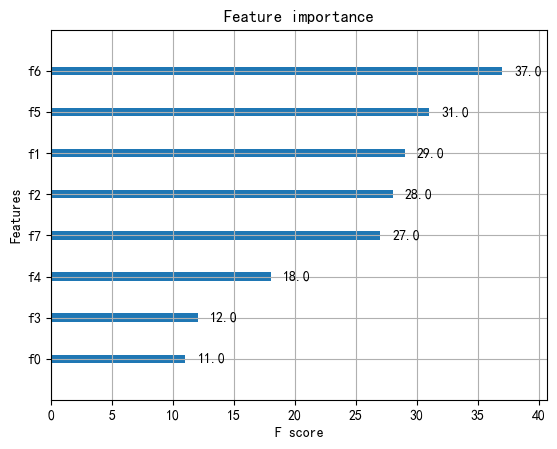

In [7]:
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
# 数据导入和切分
data = pd.read_csv('data/pima-indians-diabetes.csv')
train, test = train_test_split(data)
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)
# 参数设定
#param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }
param = {'max_depth':5, 'eta':0.1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }
# 设定watchlist用于查看模型状态
watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 10
bst = xgb.train(param, xgtrain, num_round, watchlist)
xgb.plot_importance(bst)
bst.get_score()
#{'f1': 24, 'f7': 40, 'f3': 13, 'f6': 31, 'f0': 9, 'f4': 21, 'f5': 23, 'f2': 22}